In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [41]:
img_from_dir = 'imgs_evaluate/imgs_source/ookawa_default-ookawa_angry2/parts'
for i,file in enumerate(os.listdir(img_from_dir)):
    print(f'{i:2}: {file}')

 0: all_from.png
 1: all_to.png
 2: eye_from.png
 3: eye_mouth_from.png
 4: eye_mouth_to.png
 5: eye_to.png
 6: face_from.png
 7: face_to.png
 8: mouth_from.png
 9: mouth_nose_from.png
10: mouth_nose_to.png
11: mouth_to.png
12: pose_from.png
13: pose_to.png


In [42]:
img_to_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_to_dir)):
    print(f'{i:2}: {file}')

 0: azuki_default.png
 1: ceo_default.png
 2: check1.png
 3: check2.png
 4: danda_default.png
 5: detective.png
 6: detective_02.png
 7: glasses.png
 8: idPhoto.png
 9: mio_happy.png
10: mio_shock.png
11: mio_silence.png
12: mio_u.png
13: nanko_default.png
14: ookawa_angry.png
15: ookawa_angry2.png
16: ookawa_default.png
17: ookawa_high.png
18: ookawa_regret.png
19: ookawa_smile.png
20: ookawa_surprised.png
21: pharmacist.png
22: saki.png
23: saki_glasses.png
24: sandy.png
25: takebe_default.png
26: test01.png
27: test01_02.png
28: test01_03.png
29: test01_04.png
30: test02.png
31: test02_02.png
32: test02_03.png
33: woman_default.png
34: yotaka_angry.png
35: yotaka_angry2.png
36: yotaka_bald.png
37: yotaka_bushy.png
38: yotaka_default.png
39: yotaka_gj.png
40: yotaka_smile.png
41: yotaka_smile2.png


In [54]:
data = ImageDataset(img_from_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_from = [2,5]
num_from = len(ind_batch_from)
batch_from = []
names_batch_from = []
for i in range(len(ind_batch_from)):
    batch_from.append(data[ind_batch_from[i]]['img'])
    names_batch_from.append(os.path.splitext(str(data.paths[ind_batch_from[i]]))[0])
batch_from = torch.stack(batch_from)

data2 = ImageDataset(img_to_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_to = [28,25,33,31,7]
num_to = len(ind_batch_to)
batch_to = []
names_batch_to = []
for i in range(num_to):
    batch_to.append(data2[ind_batch_to[i]]['img'])
    names_batch_to.append(os.path.splitext(str(data2.paths[ind_batch_to[i]]))[0])
batch_to = torch.stack(batch_to)

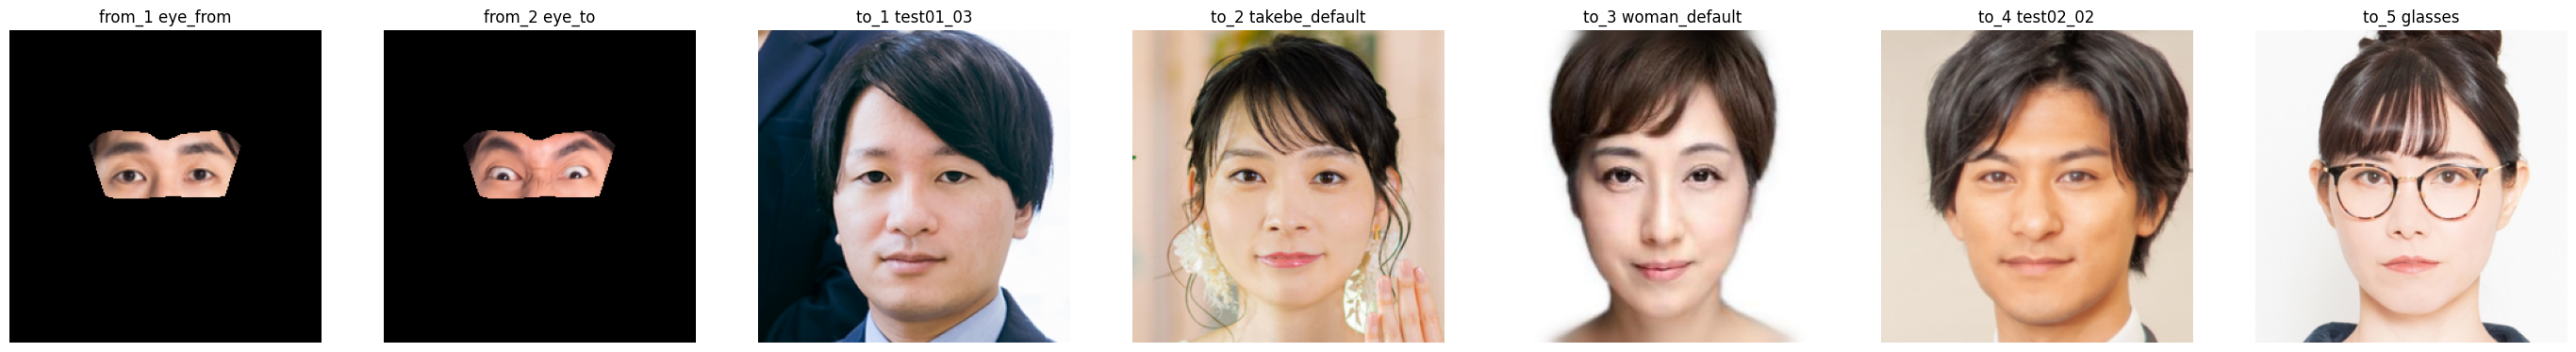

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2+num_to, figsize=(5*(num_from+num_to), 5))
for i in range(num_from):
    ax[i].imshow(batch_from[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(f"from_{i+1} {names_batch_from[i]}")

for i in range(num_to):
    ax[i+num_from].imshow(batch_to[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+num_from].set_title(f"to_{i+1} {names_batch_to[i]}")

for i in range(2+num_to):
    ax[i].axis('off')

# plt.savefig('imgs_add_test/origin.png')
plt.show()

In [57]:
# 転写元
cond_from = model.encode(batch_from.to(device))
xT_from = model.encode_stochastic(batch_from.to(device), cond_from, T=250)
cond_change = cond_from[1] - cond_from[0]

# 転写先
cond_to = torch.tensor([], device=device)
xT_to = torch.tensor([], device=device)
for i in range(num_to):
    cond_to = torch.cat([cond_to, model.encode(batch_to[i][None].to(device))], dim=0)
    xT_to = torch.cat([xT_to, model.encode_stochastic(batch_to[i][None].to(device), cond_to[i][None], T=250)], dim=0)

In [58]:
def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)

intp_from = cond_from[0][None] * (1 - alpha[:, None]) + cond_from[1][None] * alpha[:, None]
theta_from = torch.arccos(cos(xT_from[0], xT_from[1]))
x_shape = xT_from[0].shape
intp_x_from = (torch.sin((1 - alpha[:, None]) * theta_from) * xT_from[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta_from) * xT_from[1].flatten(0, 2)[None]) / torch.sin(theta_from)
intp_x_from = intp_x_from.view(-1, *x_shape)

Adain

In [57]:
import cv2

cond_change = cond_from[1] - cond_from[0]
cond = cond_to[0] + cond_change
xT_change = xT_from[1] - xT_from[0]
xT = xT_to[0] + xT_change

mask = cv2.imread("imgs_test/imgs_mask_and/yotaka_default-yotaka_angry2/mask_and.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = torch.tensor(mask.transpose(2,0,1)).to(device)
xT_a = xT_to[0][mask > 0].view(3, -1)
xT_b = xT[mask > 0].view(3, -1)

xT_a_mean = xT_a.mean(dim=1)
xT_a_std = xT_a.std(dim=1)
xT_b_mean = xT_b.mean(dim=1)
xT_b_std = xT_b.std(dim=1)

xT_c = []
for i in range(3):
    xT_c.append(torch.where(mask[i] > 0, ((xT[i]-xT_b_mean[i])/xT_b_std[i])*xT_a_std[i]+xT_a_mean[i], xT[i]))
xT_c = torch.stack(xT_c).to(device)
xT_d = xT_c/torch.linalg.norm(xT_c)*torch.linalg.norm(xT_to[0])

In [64]:
pred = model.render(xT_d[None], cond[None], T=20)

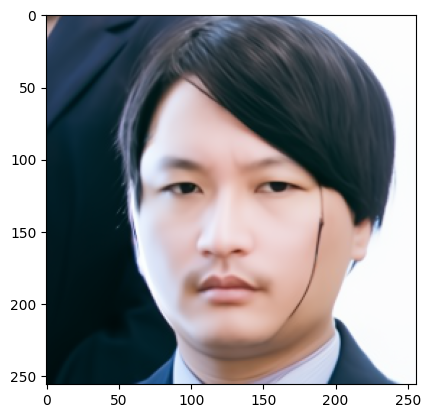

In [65]:
plt.imshow(pred[0].permute(1,2,0).cpu())

シンプル版

In [281]:
xTs = torch.tensor([], device=device)
conds = torch.tensor([], device=device)
xT_change = xT_from[1] - xT_from[0]
for i in range(num_to):
    xTs_tmp = torch.tensor([], device=device)
    conds_tmp = torch.tensor([], device=device)
    xT_to_s = torch.linalg.norm(xT_to[i].view(3,256*256), dim=1)
    for j,alp in enumerate(alpha):
        xT2 = xT_to[i] + alp * xT_change
        # xT2_s = torch.linalg.norm(xT2.view(3,256*256), dim=1)
        # for k in range(3):
        #     xT2[k] = xT2[k] / xT2_s[k] * xT_to_s[k]
        xTs_tmp = torch.cat([xTs_tmp, xT2[None]], dim=0)
        cond2 = cond_to[i] + alp * cond_change
        conds_tmp = torch.cat([conds_tmp, cond2[None]], dim=0)
    xTs = torch.cat([xTs, xTs_tmp[None]], dim=0)
    conds = torch.cat([conds, conds_tmp[None]], dim=0)

チャネル毎+mask使って

In [59]:
import cv2

is_mask = True
mask = None
def mask_norm(xT, xT2):
    mask = cv2.imread("imgs_test/imgs_mask_and/ookawa_default-ookawa_angry2/mask_eye2_or.png")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = torch.tensor(mask.transpose(2,0,1)).to(device)

    xT_a = torch.where(mask > 0, xT, 0)
    xT_a_norm = torch.linalg.norm(xT_a.view(3,256*256), dim=1)
    xT_b = torch.where(mask > 0, xT2, 0)
    xT_b_norm = torch.linalg.norm(xT_b.view(3,256*256), dim=1)
    xT_c = []
    for i in range(3):
        xT_c.append(torch.where(mask[i] > 0, xT_b[i]/xT_b_norm[i] * xT_a_norm[i], xT2[i]))
    xT_c = torch.stack(xT_c).to(device)
    return xT_c

xTs = torch.tensor([], device=device)
conds = torch.tensor([], device=device)
xT_change = xT_from[1] - xT_from[0]
for i in range(num_to):
    xTs_tmp = torch.tensor([], device=device)
    conds_tmp = torch.tensor([], device=device)
    xT_to_norm = torch.linalg.norm(xT_to[i].view(3,256*256), dim=1)
    for j,alp in enumerate(alpha):
        xT2 = xT_to[i] + alp * xT_change
        if is_mask:
            xT2 = mask_norm(xT_to[i], xT2)
        xT2_norm = torch.linalg.norm(xT2.view(3,256*256), dim=1)
        for k in range(3):
            xT2[k] = xT2[k] / xT2_norm[k] * xT_to_norm[k]
        xTs_tmp = torch.cat([xTs_tmp, xT2[None]], dim=0)
        cond2 = cond_to[i] + alp * cond_change
        conds_tmp = torch.cat([conds_tmp, cond2[None]], dim=0)
    xTs = torch.cat([xTs, xTs_tmp[None]], dim=0)
    conds = torch.cat([conds, conds_tmp[None]], dim=0)

slerp横

In [286]:
xTs = torch.tensor([], device=device)
conds = torch.tensor([], device=device)
for i in range(num_to):
    xTs_tmp = torch.tensor([], device=device)
    conds_tmp = torch.tensor([], device=device)
    xT_change = 0
    xT_to_s = torch.linalg.norm(xT_to[i].view(3,256*256), dim=1)
    xT_to2 = xT_to[i]
    for j,alp in enumerate(alpha):
        xT2 = xT_to2 + xT_change
        xT2_s = torch.linalg.norm(xT2.view(3,256*256), dim=1)
        for k in range(3):
            xT2[k] = xT2[k] / xT2_s[k] * xT_to_s[k]
        
        xTs_tmp = torch.cat([xTs_tmp, xT2[None]], dim=0)
        xT_to2 = xT2
        if j+1 < len(alpha):
            xT_change = intp_x_from[j+1] - intp_x_from[j]
        # xT_to_s = torch.linalg.norm(xTs_tmp[j])
        cond2 = cond_to[i] + alp * cond_change
        conds_tmp = torch.cat([conds_tmp, cond2[None]], dim=0)
    xTs = torch.cat([xTs, xTs_tmp[None]], dim=0)
    conds = torch.cat([conds, conds_tmp[None]], dim=0)

In [60]:
preds = torch.tensor([], device=device)
for i in range(num_to):
    preds_tmp = torch.tensor([], device=device)
    for j in range(len(alpha)):
        pred = model.render(xTs[i,j][None], conds[i,j][None], T=20)
        preds_tmp = torch.cat([preds_tmp, pred], dim=0)
    preds = torch.cat([preds, preds_tmp[None]], dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

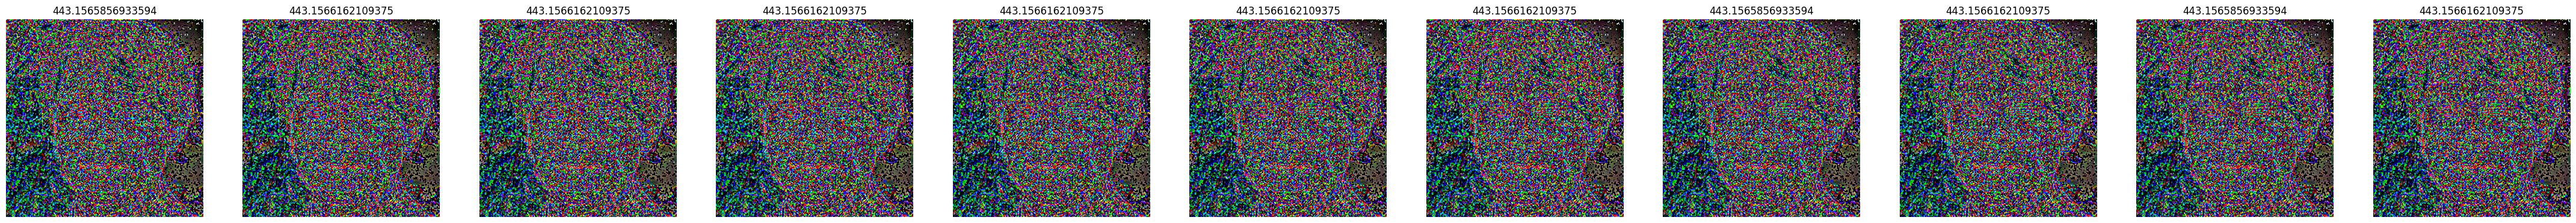

In [61]:
fig, ax = plt.subplots(1, len(xTs[0]), figsize=(len(xTs[0])*5,5))
for i in range(len(xTs[0])):
    ax[i].imshow(xTs[0,i].permute(1,2,0).cpu())
    ax[i].axis('off')
    ax[i].set_title(float(torch.linalg.norm(xTs[0,i])))

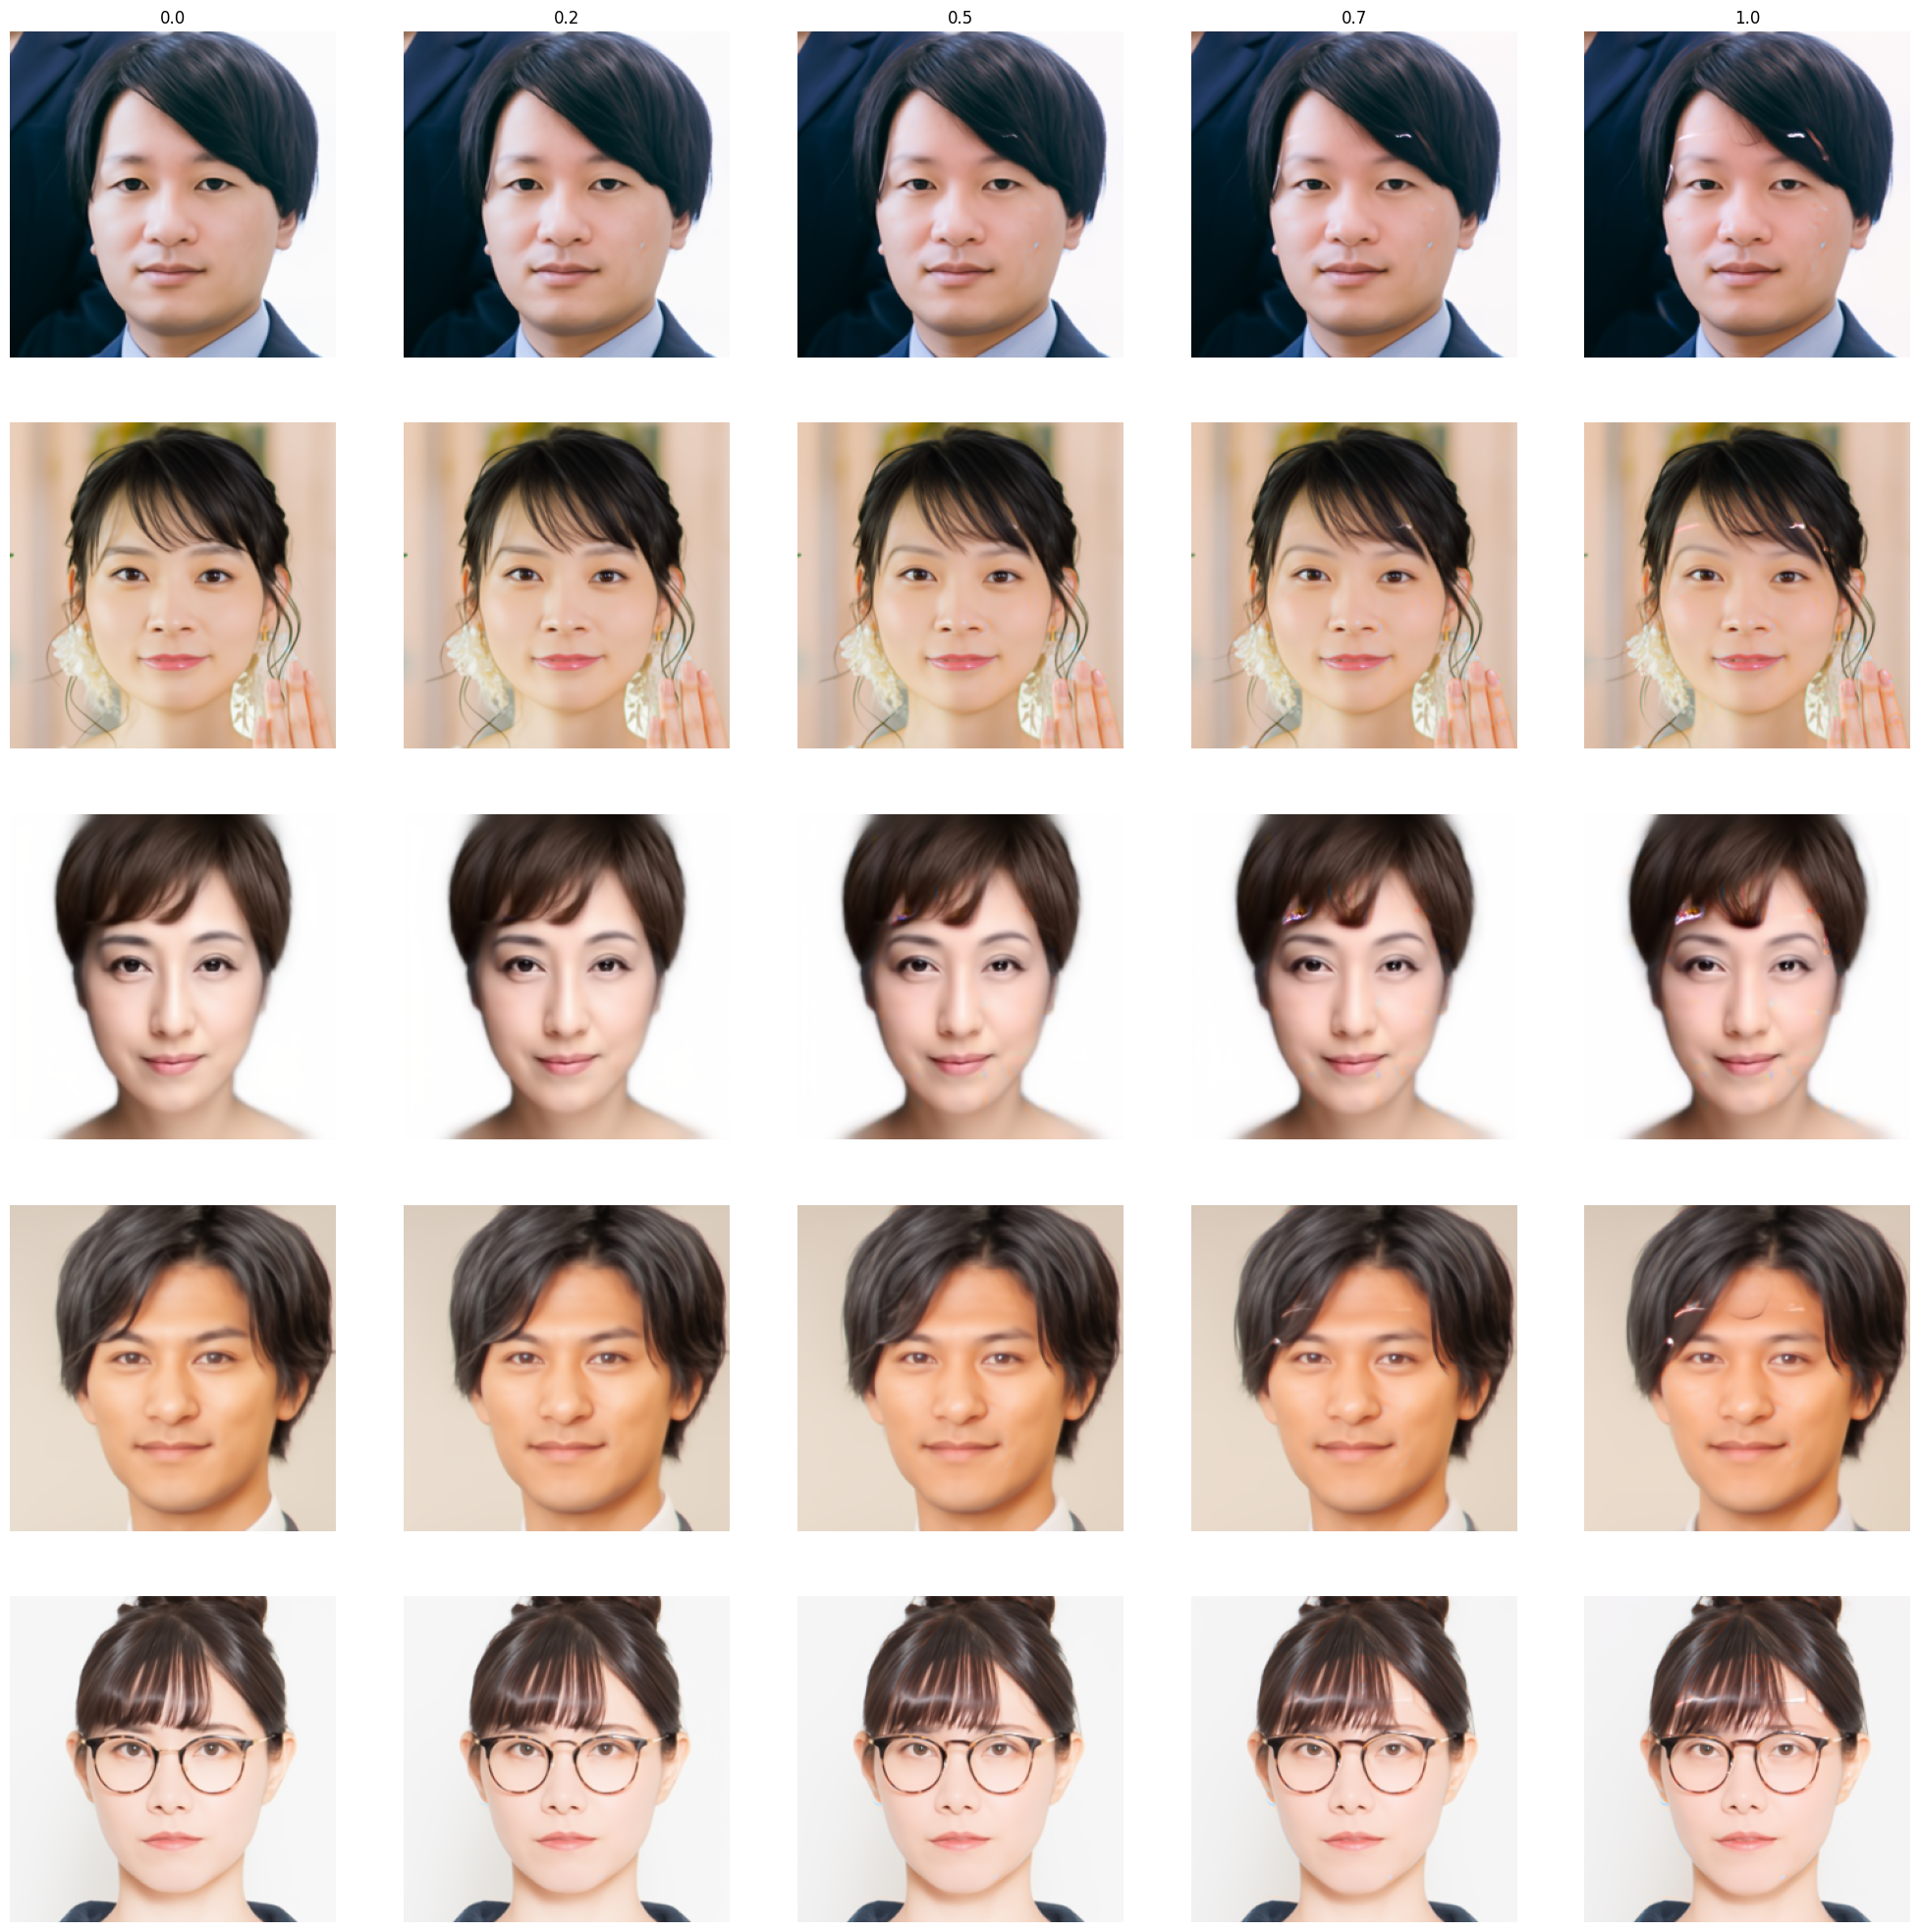

In [62]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_to, num_show, figsize=(5*num_show, 5*num_to))
for i,pred in enumerate(preds):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

# plt.savefig('imgs_add_test/xT/xT_transfer_mouth.png')

In [63]:
from PIL import Image

preds_pil = []
for pred in preds:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pil.append(pred_pil)

## gifの保存

### 名前自動（まとめて）

In [64]:
dst_dir = "paper_xT/imgs_transfer_xT_new/"
for i,pred_pil in enumerate(preds_pil):
    frs_dir = f"{dst_dir}{names_batch_from[0]}2{names_batch_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=3000//(len(alpha)),
        loop=0,
    )

## 静止画像（フレーム）の保存

### 名前自動（まとめて）

In [65]:
from torchvision.utils import save_image

dst_dir = "paper_xT/imgs_transfer_xT_new/"
# select_ind = {0,12,24,36,47,59}
select_ind = {0,2,4,5,6,8,10}
for i,pred in enumerate(preds):
    frs_dir = f"{dst_dir}{names_batch_from[0]}2{names_batch_from[1]}-trans-{names_batch_to[i]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        if j in select_ind:
            file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
            save_image(p, file_name, format='PNG')